# Homework 8 : Carseats Datasets

In [102]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV




In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC , DecisionTreeRegressor as DTR , plot_tree , export_text)
from sklearn.metrics import (accuracy_score , log_loss)
from sklearn.ensemble import  (RandomForestRegressor as RF, GradientBoostingRegressor as GBM) 
from ISLP.bart import BART

# 1.a) Split Data into Train and Test Sets 

In [3]:
carseats = load_data('Carseats')

In [4]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [ ]:
Carseats = load_data('Carseats')

In [6]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
features_name = list(D.columns)
X = np.asarray(D)

In [20]:
y = Carseats.Sales

In [21]:
y

0       9.50
1      11.22
2      10.06
3       7.40
4       4.15
       ...  
395    12.57
396     6.14
397     7.41
398     5.94
399     9.71
Name: Sales, Length: 400, dtype: float64

In [38]:
# Split the data into training and test sets
(X_train , X_test , y_train , y_test) = skm.train_test_split(D,
                                                                   y ,
                                                                   test_size=0.5,
                                                                   random_state=0)

In [39]:
X_train.shape , X_test.shape, y_train.shape , y_test.shape

((200, 11), (200, 11), (200,), (200,))

## 1.b) Fit the Regression Tree

In [40]:
dtr = DTR(criterion='squared_error', random_state=0)
dtr.fit(X_train, y_train) 

DecisionTreeRegressor(random_state=0)

In [42]:
y_pred = dtr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 6.198309500000001


In [44]:
from sklearn.metrics import mean_squared_error

baseline = np.mean(y_test)
baseline_mse = mean_squared_error(y_test, [baseline]*len(y_test))
print("Baseline MSE:", baseline_mse)


Baseline MSE: 7.3638146775


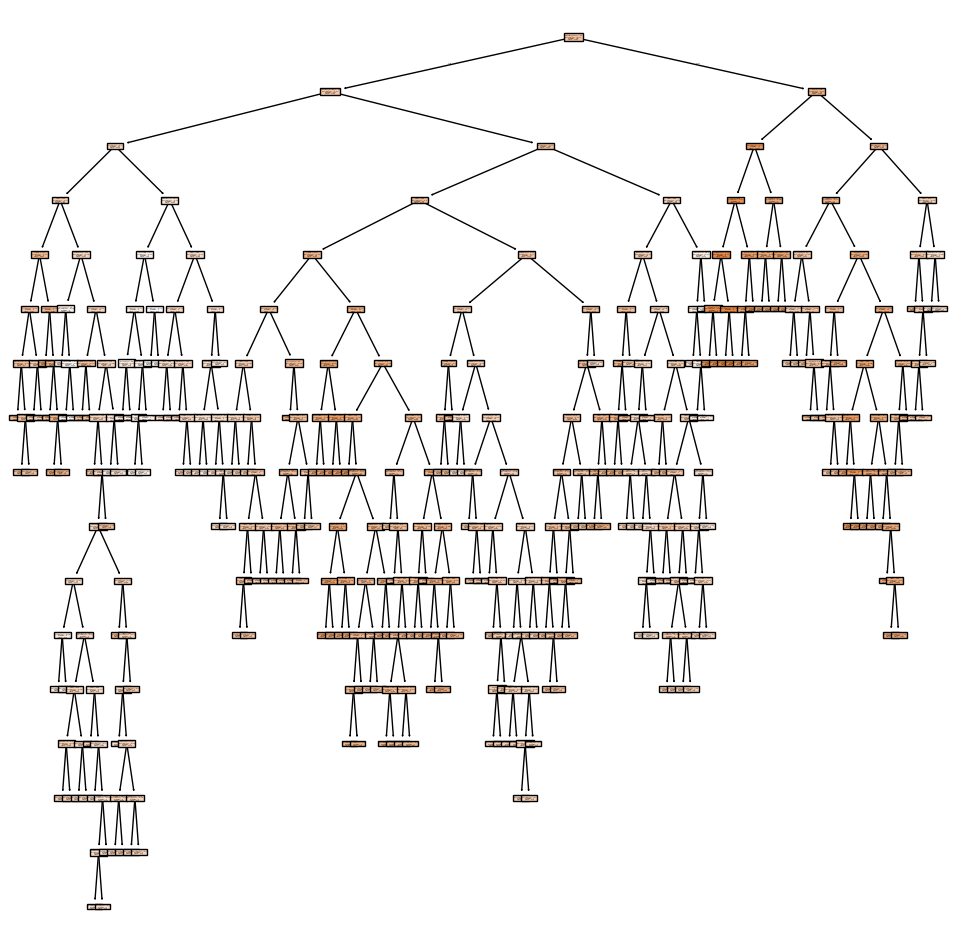

In [43]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plot_tree(dtr, feature_names=features_name, filled=True)
plt.show()

## c) Applying Cross-Validation 

In [48]:
# Get effective alphas and corresponding impurities
path = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [51]:
# Store results
cv_scores = []

for alpha in ccp_alphas:
    model = DTR(random_state=0, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_mean_squared_error', cv=5)
    cv_scores.append(-np.mean(scores))  # make positive

In [52]:
best_alpha = ccp_alphas[np.argmin(cv_scores)]
print("Best alpha:", best_alpha)

Best alpha: 0.1814862011904719


In [54]:
dtr_pruned = DTR(random_state=0, ccp_alpha=best_alpha)
dtr_pruned.fit(X_train, y_train)

y_pred_pruned = dtr_pruned.predict(X_test)
# Calculate MSE for the pruned tree
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print("Test MSE Pruned:", mse_pruned)

Test MSE Pruned: 5.13160070941571


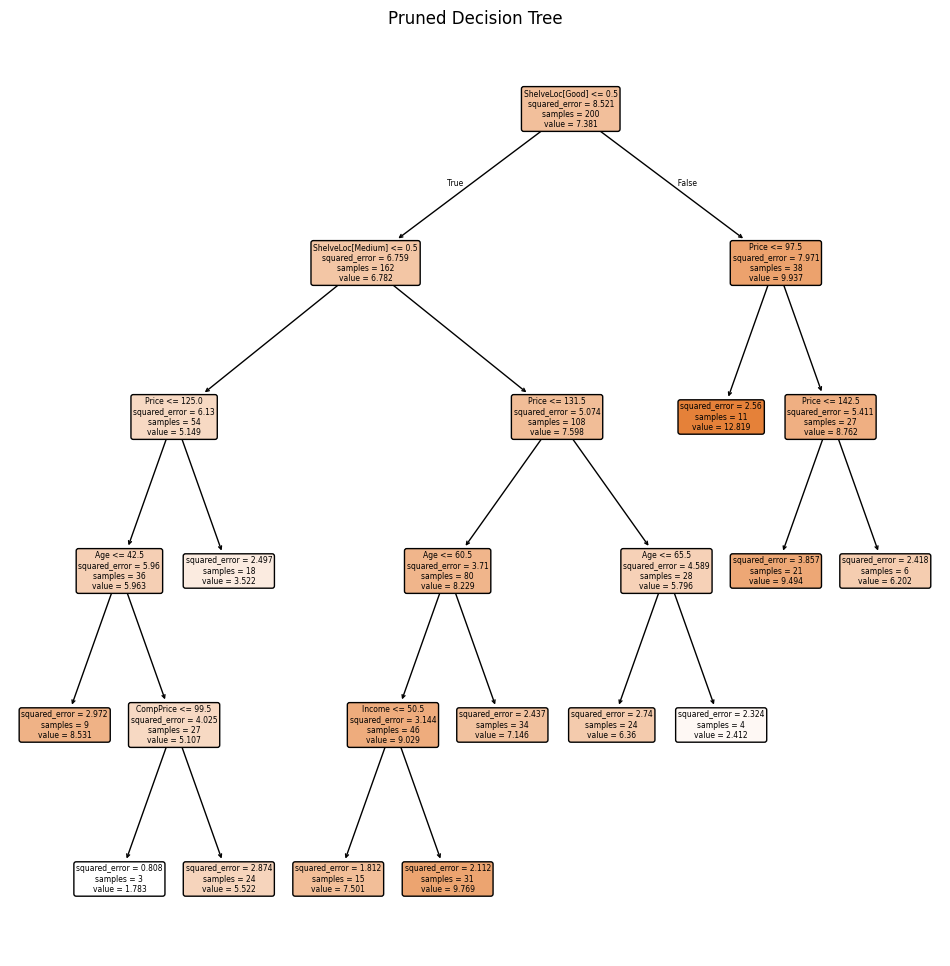

In [57]:
plt.figure(figsize=(12,12))
plot_tree(dtr_pruned, 
          feature_names=features_name, 
          filled=True, 
          rounded=True)
plt.title("Pruned Decision Tree")
plt.show()

# Bagging Ensemble 

In [58]:
bag_carSales= RF(max_features=X_train.shape[1], random_state=0)
bag_carSales.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=0)

2.803607344399998

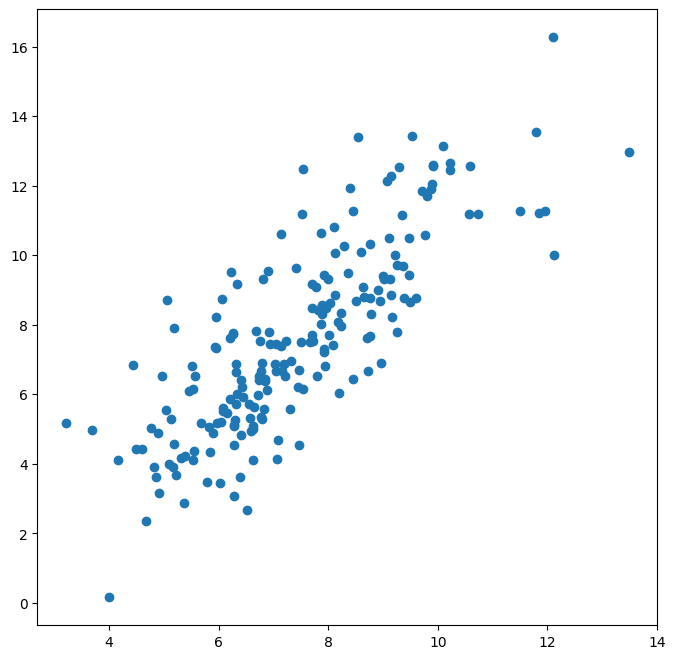

In [ ]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_carSales.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

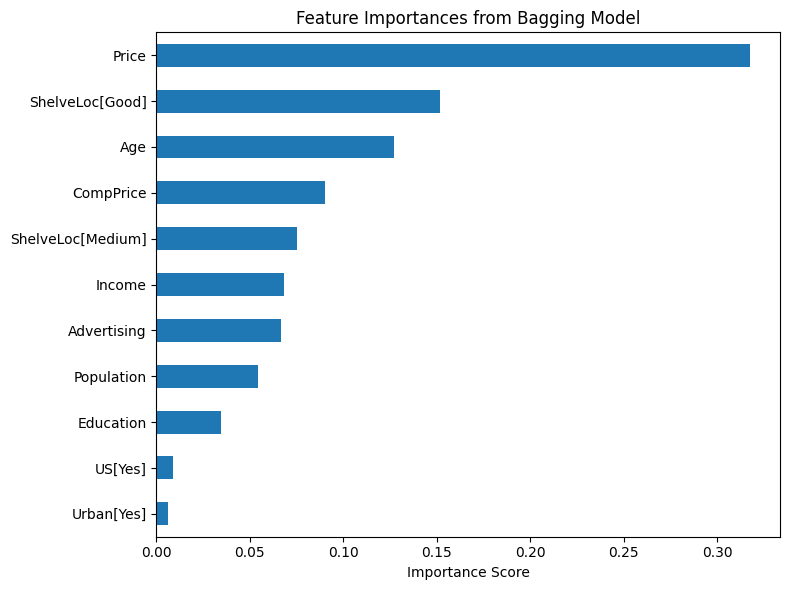

In [61]:
# Get importance
importances = bag_carSales.feature_importances_
feature_names = features_name

# Plot
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importances from Bagging Model")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## Random Forest 

In [62]:
# Use a smaller m (e.g., sqrt(p))
rf = RF(n_estimators=500, max_features=5, random_state=0)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print("Test MSE (Random Forest):", mse_rf)

Test MSE (Random Forest): 2.7427532009580036


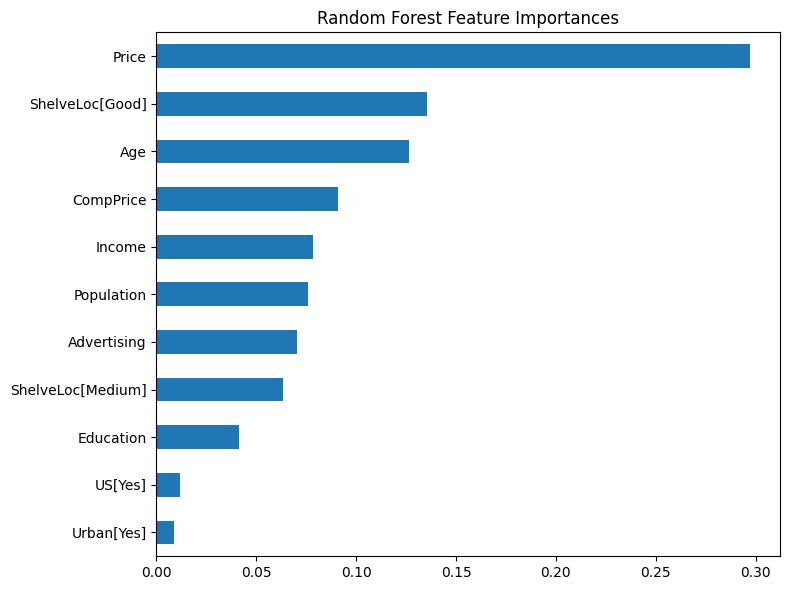

In [64]:
importances = rf.feature_importances_
pd.Series(importances, index=feature_names).sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


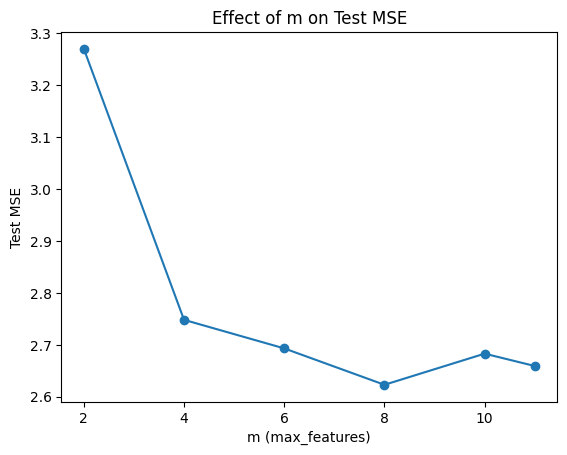

In [65]:
m_values = [2, 4, 6, 8, 10, X.shape[1]]  # or use range
results = []

for m in m_values:
    model = RF(n_estimators=500, max_features=m, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((m, mse))

# Plot
m_vals, mse_vals = zip(*results)
plt.plot(m_vals, mse_vals, marker='o')
plt.xlabel("m (max_features)")
plt.ylabel("Test MSE")
plt.title("Effect of m on Test MSE")
plt.show()


## Boosting 

In [67]:
hitters = load_data('Hitters')

## 1.a 

In [89]:
# Drop rows with missing salary
hitters = hitters.dropna(subset=["Salary"]).copy()

# Log-transform the target variable
hitters["LogSalary"] = np.log(hitters["Salary"])

# Now define X and y
X_hitter = hitters.drop(columns=["Salary", "LogSalary"])
X_hitter = pd.get_dummies(X_hitter, drop_first=True)  # handle categorical vars

y_hitter = hitters["LogSalary"]


## b) training set consisting of the first 200

In [90]:
X_hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False


In [92]:

# One-hot encode categorical variables
X_h= pd.get_dummies(X_hitter, drop_first=True)

In [93]:
X_h.abs()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,True,False,True
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,False,False,False
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,False,True,False
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,False,False,False


In [94]:
# Train-test split based on index (first 200 for training)
X_train_hitter = X_h.iloc[:200, :]
X_test_hitter = X_h.iloc[200:, :]
y_train_hitter = y_hitter.iloc[:200]
y_test_hitter= y_hitter.iloc[200:]

In [95]:
X_train_hitter.shape, X_test_hitter.shape, y_train_hitter.shape, y_test_hitter.shape

((200, 19), (63, 19), (200,), (63,))

In [96]:
y_hitter.isnull()

1      False
2      False
3      False
4      False
5      False
       ...  
317    False
318    False
319    False
320    False
321    False
Name: LogSalary, Length: 263, dtype: bool

## C) boosting on the training set with 1,000 trees

In [97]:
shrinkage_values = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
train_mse = []

for lr in shrinkage_values:
    model = GBM(n_estimators=1000, learning_rate=lr, random_state=0)
    model.fit(X_train_hitter, y_train_hitter)
    y_train_hitter_pred = model.predict(X_train_hitter)
    train_mse.append(mean_squared_error(y_train_hitter, y_train_hitter_pred))

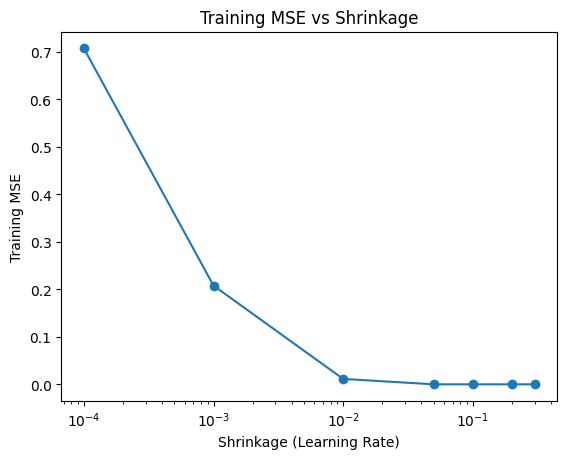

In [98]:
# Plot
plt.plot(shrinkage_values, train_mse, marker='o')
plt.xlabel("Shrinkage (Learning Rate)")
plt.ylabel("Training MSE")
plt.title("Training MSE vs Shrinkage")
plt.xscale("log")
plt.show()

## (d) Plot test MSE vs shrinkage values

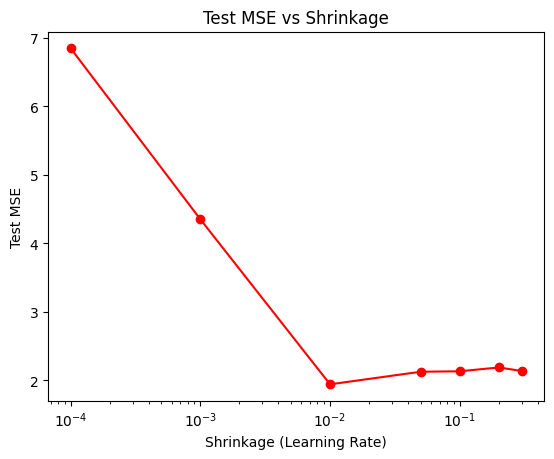

In [101]:
test_mse = []

for lr in shrinkage_values:
    model = GBM(n_estimators=1000, learning_rate=lr, random_state=0)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_test_pred))

plt.plot(shrinkage_values, test_mse, marker='o', color='red')
plt.xlabel("Shrinkage (Learning Rate)")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Shrinkage")
plt.xscale("log")
plt.show()


## e) Compare the test MSE of boosting to the test MSE

In [103]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100)).fit(X_train, y_train)
lasso = LassoCV(alphas=None, cv=5, max_iter=10000).fit(X_train, y_train)

ridge_mse = mean_squared_error(y_test, ridge.predict(X_test))
lasso_mse = mean_squared_error(y_test, lasso.predict(X_test))

print("Ridge Test MSE:", ridge_mse)
print("Lasso Test MSE:", lasso_mse)
print("Boosting Test MSE (best shrinkage):", min(test_mse))

Ridge Test MSE: 1.1247277129481055
Lasso Test MSE: 1.1566778903804666
Boosting Test MSE (best shrinkage): 1.941728970779787


## f) Most important variables in the boosted model

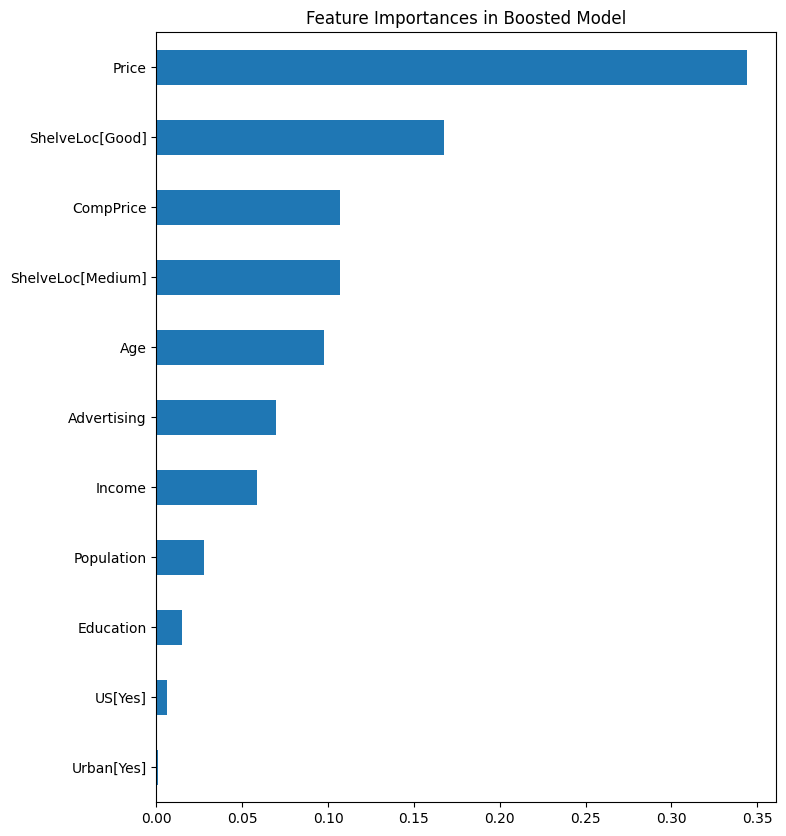

In [104]:
best_lr = shrinkage_values[np.argmin(test_mse)]
best_model = GBM(n_estimators=1000, learning_rate=best_lr, random_state=0)
best_model.fit(X_train, y_train)

importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 10))
plt.title("Feature Importances in Boosted Model")
plt.show()


 ## (g) Apply bagging and get test MSE

In [105]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(n_estimators=500, random_state=0)
bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)
mse_bag = mean_squared_error(y_test, y_pred_bag)
print("Bagging Test MSE:", mse_bag)


Bagging Test MSE: 2.668371186682007
